## HW4 - João Lazzaro

In HW4 we were asked to implement Krusell & Smith (1998) model version with endogenous labor using the algorithm proposed by the authors. To check my results, I will try to replicate the figures and coefficients presented in the working paper version of the article (http://www.econ.yale.edu/smith/rcer399.pdf) since it contains more information than the final published paper.

### Krusell & Smith Model

This section explains the model and I also comment on the strategies I took to solve it.

There is a competitive representative firm which uses capital $K_t$ and labor $H_t$ as inputs and faces a productivity shock $Z_t$. From the firm's problem we get the wages and capital return as a function of the aggregate states:

$$w(K_t,H_t,Z_t) = (1-\alpha)Z_tK_t^{\alpha}H_t^{-\alpha}$$

$$R(K_t,H_t,Z_t) = \alpha Z_tK_t^{\alpha-1}H_t^{1-\alpha}+1-\delta$$

$Z$ is assumed to have 2 values: $[0.99,1.01]$.

The economy also consists of a continuum of ex ante identical households with unit mass. Each period, agents face an idiosyncratic shock $e$ that determines whether they are employed, $e_{n,t} = 1$,or unemployed, $e_{n,t} = 0$. An employed agent earns wage $w$ per unit of labor. Markets are incomplete and agents can only save through capital accumulation, individual capital is denoted by $a_t$ and $R$ is the net rate of return. The agent must also keep track of the aggregate states of the economy. We will assume that the aggregates follow the following functional forms:

$ \ln K'= b_{0,g} + b_{1,g}\ln K$ and $ \ln H
'= d_{0,g} + d_{1,g}\ln K$ when $Z=1.01$

$ \ln K'= b_{0,b} + b_{1,b}\ln K$ and $ \ln H
'= d_{0,b} + d_{1,b}\ln K$ when $Z=0.99$


The agent recursive problem is thus the following:

$$V(a,e,K,H,Z) = max_{c,a',n} \frac{\left(c^\eta(1-n)^{1-\eta}\right)^{1-\mu}}{1-\mu} + \beta E\left[V(a',e',K',H',Z')|e,K,H,Z\right] $$

Subject to the budget constraint:

$$c \leq R(K,H,Z)a -a'+w(K,H,Z)e n $$

$$a'\geq0$$

And the beliefs: $ \ln K'= b_{0,g} + b_{1,g}\ln K$ and $ \ln H
'= d_{0,g} + d_{1,g}\ln K$ when $Z=1.01$

$ \ln K'= b_{0,b} + b_{1,b}\ln K$ and $ \ln H
'= d_{0,b} + d_{1,b}\ln K$ when $Z=0.99$

A recursive competitive equilibrium is an allocation that solves the agent problem and the aggregates moves consistently with the beliefs.

We parametrize the model following precisely Krusell & Smith parameters: 

$\beta = 0.99, \;\delta = 0.0025,\;\mu = 1$ (which implies log utility). The stochastic process for $(Z,e)$ is set so the unemployment rate in good states is 0.04 and 0.1 in bad times. The average duration of good and times is 8 periods and the average duration of unemployment is 1.5 in good times and 2.5 in bad times.

### Solving the Consumer Problem

Due to the quantity of states, this problem is hard to solve. The usual methods I used in the previous homeworks were not able to handle this problem. Although Value Function Iteration or Euler Equation iteration worked in this case, they both were taking a ridiculous amount of time. Approximately 4 hours to solve the agent problem with a fairly small grid. The challenge was to solve the system of equations (in the case of Euler Equations) or the optimization problem (VFI) for labor and assets. It is also obvious that discrete state space that I use often for simple problems, is also not an option since it would require an enormous amount of memory. 

Instead of trying to speed up the solver, I decided to try another approach. Carroll's endogenous grid method proved to be very efficient in handling this problem. With a grid 6 times larger, the method solves the agent problem in less than 5 minutes since it does not involve any optimization. Usually, the endogenous grid method does not apply directly to endogenous labor problems (in the simple growth model the method would require some tweaks (see https://www.sas.upenn.edu/~jesusfv/Endogenous_Grid.pdf for a discussion) but since wages are exogenous to consumer decisions in this case it works:

Consider the labor labor consumption FOC:

$$ \frac{u_n}{u_c} = w$$

Plugging the functional forms, we can solve for $n$:

$n^*(c,e,K,H,Z) = 1-\frac{1-\eta}{\eta}\frac{c}{w(K,H,Z)}$ if $e = 1$ and $n=0$ otherwise.

From the intertemporal Euler equation we have:

$$u_c(c,n) = \beta E[ R(K',H',Z')u_c(c',n')| e,K,H,Z]$$

The strategy here is to define a grid for assets in $t+1$ and to guess a functional form for $c$ so given that gues and the labor equation found above,  the right hand side of this eqution is a constant (named here RHS). Plugging the function forms for $u$ and $n^*$, we get that:

$$c = \left[ \frac{RHS}{\eta} \left( \frac{(1-\eta)}{\eta w(K,H,Z)}\right)^{-(1-\mu)(1-\eta)}\right]^\frac{-1}{\mu} $$
if $e>0$ and $c = \left[ \frac{RHS}{\eta}\right]^\frac{-1}{\mu}$ otherwise.

With these equations we may proceed to an usual implementation of the endogenous grid method as in Violante's slides. The code below implements the method:

In [6]:
using Interpolations, ProgressMeter
using Distributions, Random, DataFrames, GLM
#using Distributed, SharedArrays
include("CRRA_utility.jl")
include("functions.jl") #load some auxiliary, not interesting functions

#Wages functions
R(K::Float64,H::Float64,z::Float64;α=α::Float64,δ=δ::Float64)= z*α*K^(α-1.0)*H^(1.0-α) + (1.0-δ)
w(K::Float64,H::Float64,z::Float64;α=α::Float64) = z*(1.0-α)*K^(α)*H^(-α)

#Law of motion functions for aggregate states
K1(K::Float64,z::Float64;b=b::Array{Float64,2},Z= Z::Array{Float64,1}) = exp(b[findfirst(Z.==z),1]+b[findfirst(Z.==z),2]*log(K))
H0(K::Float64,z::Float64;d=d::Array{Float64,2},Z = Z::Array{Float64,1}) = exp(d[findfirst(Z.==z),1]+d[findfirst(Z.==z),2]*log(K))

#Defining asset investment function:
#c(a,e, n ,a1,k,h,z) =  R(k,h,z)*a+e*w(k,h,z)*n-a1
a1star(c,a,e,k,h,z) = R(k,h,z)*a-c+w(k,h,z)*e*nstar(c,e,k,h,z)

#defining optimal labor choice. This comes from labor FOC:
nstar(c,e,k,h,z;η = η,lbar = lbar) = (e>0.0)*min(max((lbar - (1-η)/η * c/w(k,h,z)),0.0),lbar)


function ENDOGENOUSGRID_KS(A::Array{Float64,1},A1::Array{Float64,1},E::Array{Float64,1},Z::Array{Float64,1},transmat::Array{Float64,2},states::NTuple,
    K::Array{Float64,1}, H::Array{Float64,1} ,b::Array{Float64,2},d::Array{Float64,2};α=α::Float64,β = β::Float64, η=η::Float64, μ=μ::Float64,
     tol = 1e-6, lbar=lbar::Float64 ,  policy= zeros(nA,nE,nK,nH,nZ)::Array{Float64,6},update_policy=0.5::Float64,updaterule = false)
    #This function solves the agent problem using the endogenous grid method.
    #A: Individual Asset grid in t!
    #A: Individual Asset grid in t+1
    #E: Individual productivity grid
    #Z: Aggregate shocks grid
    #transmat: transmat object with all the transition matrices
    #states: A tuple which each element is a pair of possible states
    #K: Aggregate capital grid
    #H: Aggregate labor grid
    #b: capital law of motion coefficients
    #d: labor law of motion coefficients

    #OPTIONAL ARGUMENTS
    #update_policy: Damping parameter
    #policy: Initial grid guess for the policy function
    #udpdaterule: false for regular update rule, true for extrapolation (see below)
    #the othere parameters are self explanatory.
    nA::Int64 = length(A)
    nZ::Int64 = length(Z)
    nE::Int64 = length(E)
    nH::Int64 = length(H)

    #RETURN the grid for the agents policy functions.

    #Guess for policy functions
    #itpn = LinearInterpolation((A,E,K,H,Z),policy[:,:,:,:,:,2],
    #extrapolation_bc=Line())
    itpc = LinearInterpolation((A,E,K,H,Z),policy, extrapolation_bc=Line())
    policy_c(a,e,k,h,z) = itpc(a,e,k,h,z)
    policy_n(a,e,k,h,z) = nstar(policy_c(a,e,k,h,z),e,k,h,z)
    policy_a(a,e,k,h,z) = a1star(policy_c(a,e,k,h,z),a,e,k,h,z)


    #Loop st uff:
    policy1= copy(policy) #To store updated values
    prog = ProgressUnknown("Iterations:") #timing and iteration counter, cool stuff
    iteration ::Int64 = 0
    distance::Float64 = 1.0
    dist1 = policy1.-policy #

    while distance > tol
        #the function below returns the new policygrid
    @inbounds   innerforloop!(policy1,policy_c,policy_n,b,d;
            A=A,E=E,Z=Z,K=K,H = H,lbar = lbar,A1=A1)

        #check convergence
        distance = maximum(abs.(policy1-policy))

        #error if no convergence
        if distance == NaN || distance == Inf
            error("Agent Problem did not converge")
        end

        #see http://www.econ2.jhu.edu/People/CCarroll/SolvingMacroDSOPs.pdf (also
        #in references directory) section 4.2 for an explanation of the parameter φ
        #it is a clever update rule.
        dist = copy(dist1)
        dist1 = policy1.-policy
        if iteration >1
            φ = dist1./dist
            φ[dist1.<tol] .= 0.0
            φ[φ.>1.0] .=0.5
            φ[0.9.<φ.<=1.0] .= 0.9
        end
        if iteration > 4 && updaterule
            policy = (policy1.- φ.*policy)./(1.0.-φ)
        else
            policy = update_policy*policy1 + (1.0-update_policy)*policy1
        end

        #update the policy functions:
        itpc = LinearInterpolation((A,E,K,H,Z),policy, extrapolation_bc=Line())
        ProgressMeter.next!(prog; showvalues = [(:Distance, distance)])
        iteration +=1
        if iteration == 500 || iteration > 1200
            update_policy = rand()
        elseif iteration >10000
            break
        end

    end
    ProgressMeter.finish!(prog)
    println("Agent problem finished with a distance of $(distance)")
    return  policy
end

function innerforloop!(policy1::Array{Float64,5}, policy_c::Function,policy_n,b,d;
    A1=A1,E=E,Z=Z,K=K,H = H,lbar = lbar,A=A)
    #Returns the updated policy grid given the policies functions
    A0 = copy(A1)
    for ki = 1:length(K)
        k=K[ki]
         for (zi,z) = enumerate(Z),(hi,h) = enumerate(H),(ei,e) = enumerate(E)
            for (ai,a1) = enumerate(A1) #a1 is assets tommorow
            #Find the level of assets and consumption today that generates a1 given the policy functions
                policy1[ai,ei,ki,hi,zi],A0[ai] = EE(a1;e=e,z=z,K=k,H=h,b=b,d=d,η=η,policy_c = policy_c)
            end

            #sort the asset today (needed for the Interpolation function)
            ordem = sortperm(A0)
            #interpolate consumption today as a function of today's:
            itpc0 = LinearInterpolation(A0[ordem],policy1[ordem,ei,ki,hi,zi],extrapolation_bc=Line())

            #Update the grid:
            for ai = 1:length(A)
                if A0[1]<=A1[ai]
                    policy1[ai,ei,ki,hi,zi] = itpc0(A1[ai])

                else #If borrowing constraint bids:
                    policy1[ai,ei,ki,hi,zi] = η*(R(k,h,z)*A0[ai]- A1[1] + w(k,h,z)*e*lbar) 
                    #This formula comes from finding the solution of the fixed point c:
                    # c = R(k,h,z)*A0[ai]- A1[1] + w(k,h,z)*e*nstar(c,e,k,h,z)
                end
            end
        end
    end
    return policy1
end

function EE(a1;e=E[e]::Float64,
    z=Z[z]::Float64,K=K[k]::Float64,H=H[h]::Float64,states=states::NTuple{4,Array{Float64,1}},
    b=b::Array{Float64,2},d=d::Array{Float64,2},η=η::Float64,Z = Z,E = E,policy_c=policy_c)
    #a1 is the asset level tommorow
    #Finds assets today as a function of assets tomorrow using the Euler equations
    i::Int64 = findfirstn(states,[z,e]) #find the current state index
    k1::Float64 = K1(K,states[i][1];b=b) #Aggregate states tommorow given today
    h1::Float64 = H0(k1,states[i][1];d=d)
    RHS1::Float64 = 0.0 #Find the RHS of the consumption FOC uct'= βE[R uct1 ']
    for e1=1:nE, z1 = 1:nZ #for all possible states tommorow
        j::Int64 = findfirstn(states,[Z[z1],E[e1]]) #find the tommorow state index
        c1::Float64 = policy_c(a1,E[e1],k1,h1,Z[z1]) #find consumption in t+1 given policy function
        a2::Float64 = a1star(c1,a1,E[e1],k1,h1,Z[z1]) #find assets in t+2 given policy function
        n1::Float64 = nstar(c1,E[e1],k1,h1,Z[z1]) #find labor in t+1 given policy function
        l1::Float64 = lbar - n1 #leisure
        RHS1 += β * transmat[i,j]*R(k1,h1,Z[z1])*uc(c1,l1) #The RHS for the state j given i
    end

    #Find the level of consumption today that generates a1 given the policy functions
    if e > 0.0
        c = (RHS1/η * ((1-η)/(η*e*w(K,H,z)))^(-(1-μ)*(1-η)))^(-1/μ)
    else
        c = (RHS1/η *lbar^(-(1-μ)*(1-η)))^(1/(η*(1-μ)-1))
    end
    #Find the consitent asset level for today (endogenous grid)
    a = c+a1-e*w(K,H,z)*nstar(c,e,K,H,z)

    return c,a
end

EE (generic function with 1 method)

### Finding the Aggregate States law of motion

The algorithm proposed by Krusell & Smith is fairly simple. It is enough to simulate the economy for a large number of agents and periods and then regress the law of motion coeffients by OLS. One quick comment on the generation of shocks is that I must make sure that the distribution is consistent. For example, I generate the series of $Z$ and for each agent the draw $e_{n,t}$ must take into acount $e_{n,t-1},Z_{t-1},Z_t$ since the shocks are not independent.

During the simulation I took some time to figure out that one must ensure that labor market clear every period (since capital is predetermined, this is not an issue in that market). To do so, we must each period guess an initial aggregate state for labor and then loop until the convergence (i.e. the aggregate of the indiviual labor decisions equals the aggregate labor guess). The code below implements the simulation:

In [7]:
function KrusselSmithENDOGENOUS(A::Array{Float64,1},A1::Array{Float64,1},
    E::Array{Float64,1},Z::Array{Float64,1},tmat::TransitionMatrix,states::NTuple{4,Array{Float64,1}},
    K::Array{Float64,1},H::Array{Float64,1},  b::Array{Float64,2},d::Array{Float64,2};
    α = α::Float64,β = β::Float64, η = η::Float64, μ=μ::Float64, tol= 1e-6::Float64,
    update_policy=0.5::Float64,updateb= 0.3::Float64,N::Int64=5000,T::Int64=11000,
    discard::Int64=1000,seed::Int64= 2803,lbar=lbar::Float64,updaterule = false)
    #This performs KS algorithm
    #A: Individual Asset grid in t!
    #A1: Individual Asset grid in t+1
    #E: Individual productivity grid
    #Z: Aggregate shocks grid
    #tmat: transmat object with all the transition matrices
    #states: A tuple which each element is a pair of possible states
    #K: Aggregate capital grid
    #H: Aggregate labor grid
    #b: capital law of motion coefficients
    #d: labor law of motion coefficients

    #OPTIONAL ARGUMENTS
    #update_policy: Damping parameter for the agent Problem
    #update_b: Damping parameter for the law of motion updates
    #N: Number of agents in the simulation
    #T: Length of the simulated time series
    #discard: number of time periods discarded for ergodicity
    #seed: set the random seed for comparable results
    #policy: Initial grid guess for the policy function
    #the othere parameters are self explanatory.


    #RETURN
    #b: Updated parameter for aggregate capital law of motions
    #d: Updated parameter for aggregate labor law of motions
    #nsim: NxT matrix with simulated labor path for each agent n
    #asim: NxT matrix with simulated assets path for each agent n
    #Ksim: T vector with simulated aggregate  capital
    #Hsim: T vector with simulated aggregate  Labor ,
    #policygrid: Grid with agents policy functions
    #K: new updated grid for aggregate capita (not used for now),
    #R2b,R2d: R-squared of b and d regressions
    #zsimd: T vector with simulated aggregate shocks
    #esim: NxT matrix with idyosincratic employment shock for each agent

    #Getting lengths
    nA::Int64 = length(A)
    nZ::Int64 = length(Z)
    nE::Int64 = length(E)
    nH::Int64 = length(H)
    nK::Int64 = length(K)

    println("Starting Krusell Smith. We are using $(nA) gridpoints for assets and")
    println("a sample of N=$(N), T=$(T). Go somewhere else, this will take a while.")

    transmat::Array{Float64,2} = tmat.P #Getting the transition matrix for the agent

    d=d::Array{Float64,2}
   
    #getting the shocks
   
    zi_shock,epsi_shock = generate_shocks(KSParameter(); z_shock_size = T, population = N)

    zsim = fill(1.01,T)
    zsim[zi_shock.==2].=0.99
    zsimd::Array{Float64,1} = zsim[discard+1:end] #Discarded simulated values for z


    esim = fill(1.0,N,T)
    esim[epsi_shock' .== 2] .= 0.0

    meanUgood = 1-mean(esim[:,zsim.==Z[2]])
    meanUbad = 1-mean(esim[:,zsim.==Z[1]])

    println("Unemployment in bad state is $(meanUbad) and $(meanUgood) in good states.")

    #predefining variables
    asim::Array{Float64,2} = rand(K[1]:0.1:K[end],N,T) #the initial assets will generate aggregate assets in the grid
    Ksim::Array{Float64,1} = ones(T)
    Hsim::Array{Float64,1} = ones(T)
    nsim::Array{Float64,2} = ones(N,T)
    R2d::Array{Float64,1} = ones(2)
    R2b::Array{Float64,1} = ones(2)

    #First guessess for Policy
    policygrid::Array{Float64,5} =  ones(nA,nE,nK,nH,nZ)
    for (zi,z) = enumerate(Z),(hi,h) = enumerate(H),(ki,k) = enumerate(K),(ei,e)=enumerate(E),(ai,a1)=enumerate(A)
        policygrid[ai,ei,ki,hi,zi] = 0.9*a1
    end
    itpc = LinearInterpolation((A,E,K,H,Z),policygrid, extrapolation_bc=Line())
    multiple100::Int64 = 0

    policy_c(a,e,k,h,z) = itpc(a,e,k,h,z)
    policy_n(a,e,k,h,z) = nstar(policy_c(a,e,k,h,z),e,k,h,z)
    policy_a(a,e,k,h,z) = a1star(policy_c(a,e,k,h,z),a,e,k,h,z)

    #loop stuff
    dist::Float64 = 1.0
    iteration::Int64 = 0
    b1::Array{Float64,2} = copy(b)
    d1::Array{Float64,2} = copy(d) #to store updated values for b and d

    Ht::Float64 = 1.0

    while (dist>tol)

        println("Solving the agent problem")
        #Solve the agent problem:
        policygrid = ENDOGENOUSGRID_KS(A,A1,E,Z,transmat,states,K, H,b,d;policy= policygrid,update_policy=update_policy,tol = tol,updaterule = updaterule)
        itpc = LinearInterpolation((A,E,K,H,Z),policygrid, extrapolation_bc=Line())
        println("Agent Problem solved!")


        loading = Progress(T, 1,"Simulating the economy.", 30)   #For loop loading bar minimum update interval: 1 second
        #Simulating the economy
        for t=1:T
            Ksim[t] = mean(asim[:,t]) #Aggregate capital is the mean of the capital decided yesterday
            #First guess for aggregate labor:
            Ht = H0(Ksim[t],zsim[t];d=d)
            #Find aggregate labor that clears the market:
            internaldist = 10.0
            its = 0
                while internaldist>1e-6 && its < 500
                    Threads.@threads for n=1:N
                        nsim[n,t] = policy_n(asim[n,t],esim[n,t],Ksim[t],Ht,zsim[t]) #Store each agent labor decision
                    end
                    Hsim[t] = mean(nsim[:,t])
                    internaldist = abs(Hsim[t] - Ht)
                    Ht = Hsim[t]
                    its+=1
                end

                if t<T
                    asim[:,t+1] .= policy_a.(asim[:,t],esim[:,t],Ksim[t],Ht,zsim[t]) #Store each agent asset decision
                end
            next!(loading) #loading bar stuff
        end


        println("Economy simulated, let's run the regression")
        #Running the regressions
        for i=1:nZ #for each state
            datad = DataFrame(Xd = log.(Ksim[discard+1:end][zsimd.==Z[i]]),
            Yd = log.(Hsim[discard+1:end][zsimd.==Z[i]])) #take log of capital and labor and dataframe it, note that I discard observations
            olsd = lm(@formula(Yd ~ Xd), datad) #regress
            d1[i,:] = coef(olsd) #get coefficients
            R2d[i] = r2(olsd) #and R2

            datab = DataFrame(Xb = log.(Ksim[discard+1:end-1][zsimd[1:end-1].==Z[i]]),
            Yb = log.(Ksim[discard+2:end][zsimd[1:end-1].==Z[i]]))#take log of capital and capital tomorrow and dataframe it, note that I discard observations
            olsb = lm(@formula(Yb ~ Xb), datab) #regress
            b1[i,:] = coef(olsb)#get coefficients
            R2b[i] = r2(olsb) #and R2

        end

        #kmin::Float64 =  max(mean(Ksim)-20.0,eps())
        #kmax::Float64 =  mean(Ksim)+20.0
        #K::Array{Float64,1} = range(kmin,stop = kmax, length = nK).^1

        #check convergence
        dist = maximum(vcat(abs.(b.-b1),abs.(d.-d1)))

        #update law of motions with a damping parameter
        b = updateb.*b1 .+ (1-updateb).*b
        d = updateb.*d1 .+ (1-updateb).*d

        iteration += 1
        println("In iteration $(iteration), law distance is $(dist)")
        println("b = $(b) and")
        println("d = $(d)")
        println("Aggregate labor mean is $(mean(Hsim))")
        println("Aggregate Capital mean is $(mean(Ksim))")
        println("Aggregate Capital R2 is $(R2b)")
        println("Aggregate Labor R2 is $(R2d)")
    end
    #=Drop first discard observations:
    Hsim = Hsim[discard+1:end]
    Ksim = Ksim[discard+1:end]
    nsim = nsim[:,discard+1:end]
    asim = asim[:,discard+1:end]
    esim = asim[:,discard+1:end]=#
    println("Krussell Smith done!")
    return b, d,  nsim, asim, Ksim, Hsim,policygrid,K,R2b,R2d,zsimd,esim
end

KrusselSmithENDOGENOUS (generic function with 1 method)

### Results

I don't run the code on this notebook because it does not look nice and also the server runs it much faster than my computer. The file main.jl replicates this results. I load the directly the results of a previous run of the code. 

In [12]:
using JLD2, FileIO
@load  "save_variables/variables_nA30.jld2"
using Plots

The coefficients I find are the following:

$$ ln K_{t+1} = 0.114 + 0.953ln K_t$$
$R^2 =0.999$ in bad times and:
$$ ln K_{t+1} = 0.128 + 0.949ln K_t$$
$R^2 =0.999$ in good times times. The result for bad times is exactly the same as Krusell & Smith while they found for good times: 
$$ ln K_{t+1} = 0.123 + 0.951ln K_t$$

For labor:
$$ ln H_{t} = -0.560 - 0.260ln K_t$$
$R^2 =0.989$ in bad times and
$$ ln H_{t} = -0.485 - 0.267ln K_t$$
$R^2 =0.992$ in good times times. Krusell & Smith results are:
$$ ln H_{t} = -0.592 - 0.252ln K_t$$
in bad times and
$$ ln H_{t} = -0.544 - 0.252ln K_t$$
in good times.


Now we plot the relationship of aggregate capital tommorow vs today which is undistinguishable from paper's figure 7:

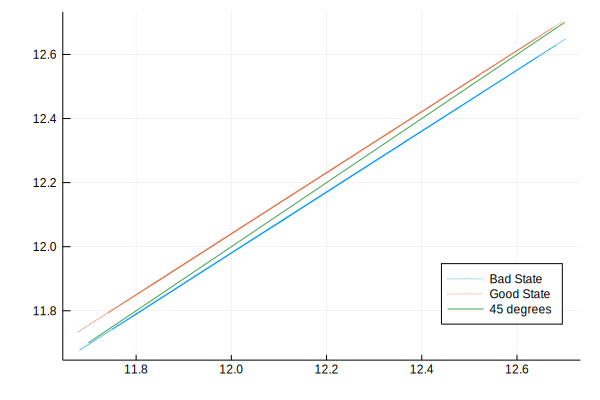

sh: dvipng: command not found
dvipng: PNG conversion failed
sh: dvipng: command not found
dvipng: PNG conversion failed


In [13]:
#Aggregate Capital vs capital:
plot((Ksim[discard+1:end-1][zsim[1:end-1].==Z[1]]) ,(Ksim[discard+2:end][zsim[1:end-1].==Z[1]]),
xlabel = "\$K_t\$",ylabel = "\$K_{t+1}\$",linestyle = :dot, label = "Bad State",legend = :bottomright)
plot!((Ksim[discard+1:end-1][zsim[1:end-1].==Z[2]]) ,(Ksim[discard+2:end][zsim[1:end-1].==Z[2]]),
linestyle = :dot, label = "Good State")
plot!(11.7:0.1:12.7 ,11.7:0.1:12.7, label = "45 degrees")

Paper figure 8 plots the relationship between aggregate labor and aggregate capital:

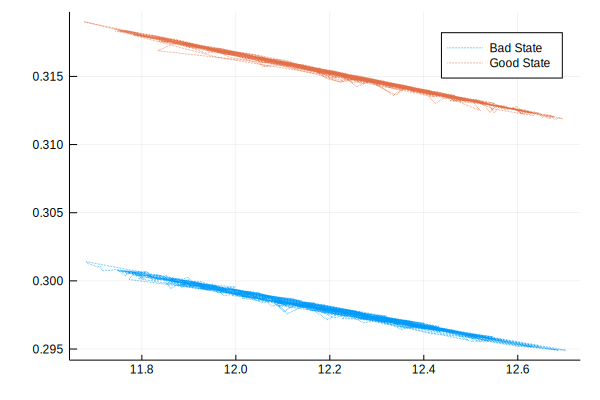

sh: dvipng: command not found
dvipng: PNG conversion failed
sh: dvipng: command not found
dvipng: PNG conversion failed


In [14]:
#Aggregate labor vs capital:
plot((Ksim[discard+1:end][zsim.==Z[1]]) ,(Hsim[discard+1:end][zsim.==Z[1]]),
xlabel = "\$K_t\$",ylabel = "\$H_t\$",linestyle = :dot, label = "Bad State")
plot!((Ksim[discard+1:end][zsim.==Z[2]]) ,(Hsim[discard+1:end][zsim.==Z[2]]),
linestyle = :dot,label = "Good State")

Although Krusell & Smith do not report the figures below, it has become somewhat common in the literature to plot the evolution of the actual Aggregate variables vs what the law of motion would imply:

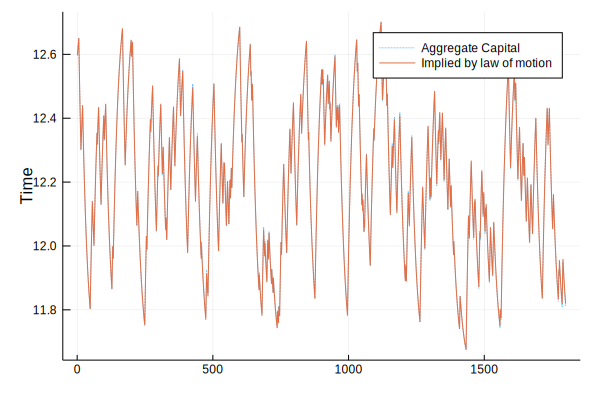

sh: dvipng: command not found
dvipng: PNG conversion failed


In [16]:

#Law of motion functions for aggregate states
K1(K::Float64,z::Float64;b=b::Array{Float64,2},Z= Z::Array{Float64,1}) = exp(b[findfirst(Z.==z),1]+b[findfirst(Z.==z),2]*log(K))
H0(K::Float64,z::Float64;d=d::Array{Float64,2},Z = Z::Array{Float64,1}) = exp(d[findfirst(Z.==z),1]+d[findfirst(Z.==z),2]*log(K))

Ksimimplied = fill(Ksim[discard+1],T-discard)
Hsimimplied = fill(Hsim[discard+1],T-discard)
for t = 1:T-discard 
    if t<T-discard
        Ksimimplied[t+1] = K1(Ksimimplied[t],zsim[t])
    end
    Hsimimplied[t] = H0(Ksimimplied[t],zsim[t])
end

plot(Ksimimplied,xlabel="\$K_t\$",ylabel="Time",label = "Aggregate Capital",linestyle = :dot)
plot!(Ksim[discard+1:end],label = "Implied by law of motion")

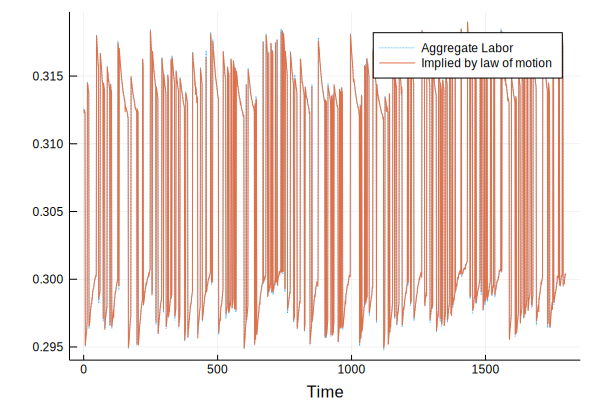

sh: dvipng: command not found
dvipng: PNG conversion failed


In [17]:

plot(Hsimimplied,ylabel="\$H_t\$",xlabel="Time",label = "Aggregate Labor",linestyle = :dot)
plot!(Hsim[discard+1:end],label = "Implied by law of motion")